In [11]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
from utils import read_wav, extract_feats, read_dataset, batch, decode
from IPython.display import Audio
from sklearn.model_selection import train_test_split
from IPython.core.display import HTML
from scipy.signal import spectrogram

from keras.layers import LSTM, Dense, Convolution1D
from keras.models import Sequential
from keras.layers.wrappers import TimeDistributed, Bidirectional

%matplotlib inline

In [65]:
HTML(r"""
<style>
    .custom-table img {padding: 40px !important;}
    .custom-table center {
        font-weight: 300;
        line-height: 1;
        letter-spacing: -0.3px;
        font-size: 20px;
    }
</style>
""")

## Обо мне
* Разработчик-аналитик в Тинькофф Банке
* Закончил ФИВТ МФТИ
* Telegram: [@standy](http://telegram.me/standy)
* Github: [@standy66](https://github.com/standy66)

## Getting started

<pre>
    $ git clone https://github.com/standy66/pycon-speech-recognition-2017
    $ cd pycon-speech-recognition-2017
    $ mkvirtualenv --python=python3 speech_recognition
    $ pip install -r requirements.txt
    $ jupyter-notebook
</pre>

## О задаче

<img src="img/asr.png" width="700"/>


**Automatic Speech Recognition (ASR)** -- задача по преобразованию звуковых данных (файлов на диске, звукового потока по сети, etc) с речью человека в текст. Задача осложняется тем, что на звуковой дорожке может присутствовать шум, музыка, говорящих может быть несколько человек, они могут перебивать друг друга. По объему вычислений и сложности задача сопоставима с распознаванием образов на изображениях.

Ранее для решения задачи распознавания речи использовались [Hidden Markov Model](https://en.wikipedia.org/wiki/Hidden_Markov_model) и [Gaussian Mixture Model](https://en.wikipedia.org/wiki/Mixture_model#Multivariate_Gaussian_mixture_model), но с развитием GPU вычислений и после прихода нейросетей, сначала в распознавание изображений, а затем и в другие области, стали использовать их.

## Нейросети

Разговор про нейросети принятно начинать с упоминания перцептрона Розенблатта, в некотором смысле копирующего биологический нейрон.

### Биологическая модель нейрона

<img src="img/neuron.png" width="600"/>

### Perceptron, Rosenblatt, 1957

<img src="img/perceptron.png" width="600"/>

Перцептрон имеет на входе некоторое количество сигналов $x_0, x_1, \ldots, x_{n-1}$ (в примере на картинке $n=3$) и $n+1$ обучаемых параметров, также называемых "весами" $w_0, w_1, \ldots, w_{n-1}$ и смещением $b$. Перцептрон выдает взвешенную сумму входов с весами с аддитивной поправкой смещения $b$, пропущенной через нелинейную монотонно возрастающую функцию активации $f$.

Если обозначить $x = (x_0, x_1, \ldots, x_{n-1}), w = (w_0, w_1, \ldots w_{n-1})$, то перцептрон считает следующую функцию 

$$y(x) = f\Big(\sum_i w_i x_i + b\Big) = f(\langle w, x \rangle + b)$$

Из этой формулы видно, что перцептрон выдает тем сильнее сигнал, чем сильнее входной вектор $x$ похож на вектор весов $w$. Можно сказать, что перцептрон подходит для детектирования определенного паттерна во входном векторе.


### Функции активации

![](img/activation_functions.png)


Функции активации должны быть дифференцируемы. Это нужно для последующего обучения нейросети градиентными методами. Кроме того, для ускорения вычислений желательно, чтобы значение производной являлось функцией от входа и посчитанного значения функции на этом входе. На рисунке выше представлены три функции активации (в порядке от верхней к нижней):

* Sigmoid, сигмоида
* tanh
* ReLU (Rectifier linear unit)

Сигмоида и tanh полезны, когда значения выхода нейрона должны быть ограничены ($(0, 1)$ и $(-1, 1)$ соответственно). ReLU полезна, когда значения на выходе нейрона должны быть положительны.


### Feedforward сети

![](img/feedforward.png)

Перцептроны обединяют в слои, а слои -- в сети. В данном примере нейросеть принимает на вход три действительных числа: $x_1$ -- площадь комнаты, $x_2$ -- расстояние до центра, $x_3$ -- количество комнат, и предсказывает стоимость аренды квартиры $y$ с данными параметрами. Поскольку все, что делает перцептрон -- это скалярное умножение, покомпонентное сложение и применение функции активации, удобно все вычисления проводить в матричной форме. $W^{(1)}, W^{(2)}, W^{(3)}, b^{(1)}, b^{(2)}, b^{(3)}$ -- параметры нейросети. $i$-тая строка в матрице весов $W^{(j)}$ соответствует вектору весов для $i$-того нейрона в $j$-том слое. $b_i^{(j)}$ -- его смещение.

Из примера выше понятно, зачем функции активации быть нелинейной -- в противном случае вся сеть заменяется на одну линейную функцию от входа.

В произвольном случае нейросеть -- это некоторый computational graph от входа с дифференцируемыми операциями в вершинах.

### Обучение нейросети

Пусть есть набор данных $\mathcal{D} = \{(x^{(1)}, y^{(1)}), \ldots, (x^{(l)}, y^{(l)})\}$, где $x$ -- вход для нейросети, $y$ -- ответ. Фиксируем некоторую архитектуру нейросети, то есть фиксируем некоторый граф вычислений со входом $x$, выходом $y$ и параметрами $\Theta$, $y = G(x, \Theta)$ -- результат работы этого графа на входе $x$. Мы хотим научиться по проивзольному $x$ предсказывать $y$, то есть аппроксимировать некоторую функцию $y = g(x)$ по точкам из $\mathcal{D}$. Мы говорим, что наша оценка $\hat{y}(x; \Theta)$ -- это реультат работы графа вычислений с параметрами $\Theta$ на входе $x$, то есть $G(x; \Theta)$. Для подбора наилучших параметров вводится функционал

$$\mathcal{L}(\Theta) = \sum_{i=1}^{n} Loss(\hat{y}(x^{(i)}, \Theta); y^{(i)})$$

, где Loss – некая дифференцируемая функция потерь, мала, когда $\hat{y}(x^{(i)}, \Theta) \approx y^{(i)}$, велика, когда $\hat{y}(x^{(i)}, \Theta) \not \approx y^{(i)}$, в примере про стоимость аренды подходит $Loss(a, b) = (a-b)^2$

Далее, оптимальный параметры находятся путем минимизации данного функционала

$$\hat{\Theta} = \text{argmin}_{\Theta} \mathcal{L}(\Theta)$$

Для минимизации используеют градиентный спуск 

$$\Theta_{n+1} = \Theta_n - \alpha \frac{\partial L}{\partial \Theta}(\Theta_n)$$

, где $\alpha$ -- learning rate (скорость обучения). Начальное приближение обычно берут около нуля, но есть и другие техники инициализации:

$$\Theta_1 \sim \mathcal{N}(0, 0.01 \cdot I_n)$$

$$\frac{\partial L}{\partial \Theta} = \sum_{i=1}^{l} \frac{\partial Loss(\hat{y}(x^{(i)}, \Theta); y^{(i)})}{\partial \hat{y}(x^{(i)}, \Theta)} \cdot \frac{\partial \hat{y}(x^{(i)}, \Theta)}{\partial \Theta}$$

$l ≈ 10^6 – 10^7$, поэтому считать сумму из $l$ элементов на каждом шаге проблематично. Решение: stochastic gradient descent (SGD).

Выбираем случайно из $\mathcal{D}$ k объектов $\{(x_{batch}^{(i)}, y_{batch}^{(i)}) : i = 1..k\} \subset \mathcal{D}$

$$\frac{\partial L}{\partial \Theta} \approx \sum_{i=1}^{k} \frac{\partial Loss(\hat{y}(x_{batch}^{(i)}, \Theta); y_{batch}^{(i)})}{\partial \hat{y}(x_{batch}^{(i)}, \Theta)} \cdot \frac{\partial \hat{y}(x_{batch}^{(i)}, \Theta)}{\partial \Theta}$$

<table class="custom-table">
<tr style="background:white">
<td style="width:50%">
![](img/gd.png)
<center>Иллюстрация градиентного спуска</center>
</td>
<td>
![](img/learning_rate_selection_2.png)
<center>О выборе learning rate</center>
</td>
</tr>
<tr style="background:white">
<td style="width:50%">
![](img/learning_rate_selection_1.png)
<center>О выборе learning rate</center>
</td>
<td>
![](img/real_loss_function.png)
<center>График функции потерь от номера итерации</center>
</td>
</tr>
</table>

### References

* [Why are deep neural networks hard to train?](http://neuralnetworksanddeeplearning.com/chap5.html)
* [An overview of gradient descent optimization algorithms](http://sebastianruder.com/optimizing-gradient-descent/)
* [Why momentum really works](http://distill.pub/2017/momentum/) 
* [cs231n Learning](http://cs231n.github.io/neural-networks-3/)

## Tensorflow

Это конечно, круто, но как использовать на практике?

Существует много фреймворков для обучения нейросетей. Мы будем использовать Tensorflow и Keras. Tensorflow предоставляет low-level (по сравнению с Keras) Python API для построения и запуска произвольных графов вычислений. Keras же предоставляет высокоуровневый интерфейс для создания многослойных архитектур нейросетевых моделей. Keras может использовать Tensorflow либо Theano в качестве бекэнда. В данном ноутбуке мы будем использовать Tensorflow backend для Keras.

Решим модельную задачу:

$$\min_y (y-4)^2$$

Понятно, что решение -- это $y=4$. Научимся на основе этой задачи задавать и заускать computational графы в Tensorflow.

Сначала определяем граф вычислений:

In [182]:
# Создаем новый граф
g = tf.Graph()

# Используем его для всех операций внутри конекста как граф по умолчанию
with g.as_default():
    # опеределяем переменную (параметры модели), которую будем подбирать, с начальным значением 0.
    # Tensorflow переменные и константы это не то же самое, что Python переменные, это операции в графе вычислений.
    y = tf.Variable(initial_value=0, dtype=tf.float32)
    print("y:\n{}\n".format(y))
    
    # y_0 -- просто Tensorflow constant со значением 4
    y_0 = tf.constant(4, dtype=tf.float32)
    print("y_0:\n{}\n".format(y_0))
    
    # Опередляем функцию потерь, которую будем минимизировать
    # Это всего лишь определение функции, а не непосредственные вычисления.
    # Такое поведение достигается за счет переопределения __add__, __sub__, __pow__ у tf.Tensor
    loss = (y - y_0) ** 2
    print("loss:\n{}\n".format(loss))
    
    # Определяем операцию шага минимизации loss с learning_rate=1e-2 с помощью GradientDescentOptimizer
    optimizer_step = tf.train.GradientDescentOptimizer(learning_rate=1e-2).minimize(loss)
    print("optimizer_step:\n{}{}".format(optimizer_step, type(optimizer_step)))

y:
<tf.Variable 'Variable:0' shape=() dtype=float32_ref>

y_0:
Tensor("Const:0", shape=(), dtype=float32)

loss:
Tensor("pow:0", shape=(), dtype=float32)

optimizer_step:
name: "GradientDescent"
op: "NoOp"
input: "^GradientDescent/update_Variable/ApplyGradientDescent"
<class 'tensorflow.python.framework.ops.Operation'>


Теперь запускаем его

In [187]:
y_history = []
loss_history = []

def log_and_print(log_list, value):
    log_list.append(value)
    print(log_list[-1])

# Создаем новую сессию, в которой будет запускаться граф
with tf.Session(graph=g) as sess:
    # Инициализируем переменные
    sess.run(tf.global_variables_initializer())
    
    # Запускаем вычисление loss и y
    log_and_print(y_history, sess.run(y))
    loss_history.append(sess.run(loss))
    
    # Запускаем один шаг градиентного спуска
    sess.run(optimizer_step)
    
    # Проверяем, что loss уменьшился, а y стал ближе к истинному значению
    log_and_print(y_history, sess.run(y))
    loss_history.append(sess.run(loss))
    
    # Запускаем еще 200 шагов градиентного спуска, сохраняя попутно loss и y
    for i in range(200):
        sess.run(optimizer_step)
        y_history.append(sess.run(y))
        loss_history.append(sess.run(loss))
    
    print(y_history[-1])

0.0
0.08
3.93106


Как видим, y приближается к истинному значению 4, а loss уменьшается

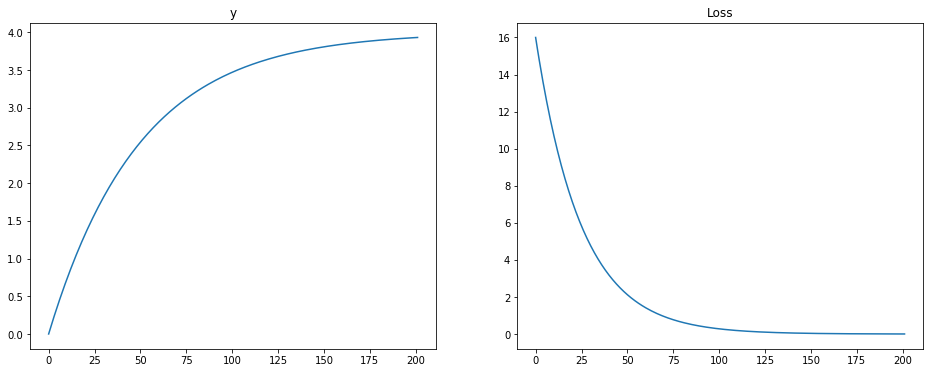

In [62]:
_, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(y_history)
axes[0].set_title("y")
axes[1].plot(loss_history)
axes[1].set_title("Loss")
plt.show()

## Keras

Для задания глубоких моделей со сложными слоями лучше пользоваться Keras. Когда Keras использует Tensorflow backend, функции и классы  из Keras можно смешивать с функциями и классами Tensorflow. Теоретически можно использовать чистый Tensorflow для задания всей модели, но практически так никто не делает. В крайнем случае, если не хочется дополнительных зависимостей, можно использовать [tf.layers](https://www.tensorflow.org/api_docs/python/tf/layers)

Решим следующую задачу: попробуем приблизить функцию $y=sin(x)$ 5-слойной нейронной сетью в некоторой окресности нуля.

In [203]:
g = tf.Graph()
with g.as_default():
    # Определяем два "плейсхолдера", в них можно будет подать рантайм значение на этапе запуска модели
    # через feed_dict параметр метода run у tf.Session
    x = tf.placeholder(tf.float32, shape=(None, 1))
    print(x)
    y = tf.placeholder(tf.float32, shape=(None, 1))
    print(y)

    # Оперделяем Keras модель Sequential, это простая последовательность слоев.
    model = Sequential()
    # Добавляем в модель 5 полносвязных слоев
    model.add(Dense(6, activation='relu', input_shape=(1,)))
    model.add(Dense(6, activation='relu'))
    model.add(Dense(6, activation='relu'))
    model.add(Dense(6, activation='relu'))
    # Активация на последнем слое tanh, т.к. sin(x) \in [-1, 1]
    model.add(Dense(1, activation='tanh'))

    # Результат применения модели ко входу x
    y_hat = model(x)

    # Определеяем функцию потерь и шаг градиентного спуска. Здесь используем AdamOptimizer, это разновидность градиентного спуска.
    loss = tf.reduce_mean((y - y_hat) ** 2)
    optimizer_step = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(loss)

Tensor("Placeholder:0", shape=(?, 1), dtype=float32)
Tensor("Placeholder_1:0", shape=(?, 1), dtype=float32)


Тренироваться будем на парах $(x, \sin(x))$, где $x \sim \mathcal{N}(0, 1)$

In [228]:
loss_history = []

sess = tf.InteractiveSession(graph=g)
sess.run(tf.global_variables_initializer())

for i in range(3000):
    # Генерируем новый батч обучающей выборки
    x_batch = np.random.normal(scale=2.0, size=(32, 1))
    y_batch = np.sin(x_batch)
    
    # Запускаем оптимизатор, передаем x_batch и y_batch через feed_dict
    loss_batch, _ = sess.run([loss, optimizer_step], feed_dict={x: x_batch, y: y_batch})
    loss_history.append(loss_batch)

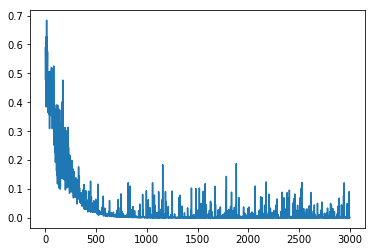

In [229]:
plt.plot(loss_history)

Протестируем сеть на входах $\frac{\pi}{2}, \frac{\pi}{4}, 0, -\frac{\pi}{4}, -\frac{\pi}{2}$

In [235]:
x_batch = np.array([np.pi/2, np.pi/4, 0, -np.pi/4, -np.pi/2]).reshape(5, -1)
y_batch_predict = sess.run(y_hat, feed_dict={x: x_batch})
print(y_batch_predict)

[[ 0.95871043]
 [ 0.69421232]
 [-0.00432443]
 [-0.6917578 ]
 [-0.9542892 ]]


In [236]:
y_batch = np.sin(x_batch)
print(y_batch)

[[ 1.        ]
 [ 0.70710678]
 [ 0.        ]
 [-0.70710678]
 [-1.        ]]


Как видим, сеть выдает довольно близкие к реальным значения

In [237]:
print(np.mean((y_batch_predict - y_batch) ** 2))

0.000842973005897


График аппроксимирующей функции близок в окресности нуля к графику синуса

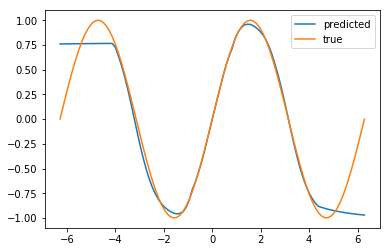

In [243]:
x_batch = np.linspace(-2*np.pi, 2*np.pi, 100).reshape(100, -1)
y_batch_predict = sess.run(y_hat, feed_dict={x: x_batch})
plt.plot(x_batch, y_batch_predict, label="predicted")
plt.plot(x_batch, np.sin(x_batch), label="true")
plt.legend()

## Рекуррентные нейросети

<img src="img/imagenet.png" width="500"/>

Выше -- пример классификации изображений с помощью [сверточных нейросетей](http://cs231n.github.io/convolutional-networks/) (СNN). Длина полосы под картинкой обозначает уверенность нейросети в том или ином классе. Как видно, CNN сеть хорошо справляется с классификацией стастических изобрежений.

Но что делать, когда есть временная размерность, которая может сильно повлиять на ответ? Например, если классифицировать нужно действия, совершаемые на каждом кадре видео, как в примере ниже. Интуитивно понятно, что есть корреляция между действиями на соседних кадрах, ведь действия начинаются и заканчиваются плавно. Кроме того, некоторый действия можно классифицировать только если иметь несоклько последовательных кадров (то есть когда последовательность и продолжительность элементарных движений важна).

<img src="img/frame_sequence.png" width="600"/>

Сети, имеющие в своей архитектуре рекуррентные соединения (от прошлого шага к текущему), называются рекуррентными. Их можно рассматривать как и обычные ациклические графы вычислений, если рекуррентность "развернуть" по времени. Кроме того, о состоянии, передающимся с помощью рекуррентного содеинения, можно думать как о ячейке памяти, в которую рекуррентная сеть может писать или читать.

<img src="img/vanilla_rnn_unroll.png" width=700/>

В примере выше задана однослойная однонаправленная рекуррентная сеть, считывающая последовательнсть $x_0, \ldots x_t$ и выдающая последовательность векторов (своего скрытого состояния) $h_0, \ldots h_t$. Сверху можно расположить еще один полносвязный слой, чтобы по $h_t$ получать $y_t$. В зависимости от того, как работает блок A, выделяют несколько архитектур рекуррентных нейросетей.

### Vanilla RNN

Самый простой тип рекуррентных нейросетей.


<img src="img/vanilla_rnn.png" width=700/>

$h_t$ и $y_t$ рассчитывается по формулам выше

#### Проблема длинных зависимостей


<img src="img/long_range_1.png" width=500/>

Рекуррентные сети в целом оказываются очень полезным инструментом для работы с последовательностями. Они способны запоминать информацию на некоторые промежутки времени, и потом делать предсказания, основанные на это информации. На картинке выше нейросеть предсказывает значение $h_3$, на основе $x_0$ и $x_1$. Такая зависимость называется короткой (short-term dependency), посколько нейросети достаточно запомнить информацию на шаге 0 и 1 лишь на несколько тактов вперед, чтобы сделать выводы на шаге с индексом 3.


<img src="img/long_range_2.png" width=600/>

Наоборот, на этой картинке при достаточно большом t (скажем, 100 или 200), нейросети придется "тащить" информацию на протежении большого количества тактов в своем скрытом состоянии. Оказывается, Vanilla RNN обладают такими свойствами, которые не позволяют им выучить матрицу перехода $W_hh$ для хранения таких длинных зависимостей. Об этой проблеме подробно написал Yoshua Bengio в [своей работе](http://www-dsi.ing.unifi.it/~paolo/ps/tnn-94-gradient.pdf) в 1994 году.

### LSTM -- Long Short-Term Memory

<img src="img/lstm.png" width=700/>
<img src="img/lstm_legend.png" width=400/>

Для борьбы с проблемами длинных зависимостей была придумана другая архитектура рекуррентных ячеек, назвыаемая LSTM. Общее строение ячеек LSTM представлено на рисунке выше. Основное отличие от Vanilla RNN -- в LSTM есть специальная дополнительная "ячейка памяти" $C_t$, которая со временем претерпевает всего два изменения -- поэлементное сложение и умножение. Поэлементность этих операций позволяет градиентному спуску эффективно выучивать длинные зависимости.

<img src="img/lstm_memory_cell.png" width=700/>

Кроме ячейки памяти LSTM содержит три "затвора" -- input gate $i_t$, forget gate $f_t$, output gate $o_t$.

<img src="img/lstm_forget_gate.png" width=700/>

Forget gate $f_t$ показывает, какую информацию ячейке нужно "забыть" на текущем шаге ($C_{t-1}$ домножаетяся на него поэлементно). Из-за использования сигмоидальной активации получаются значения как раз в интервале $(0, 1)$. 1 означает, что значение нужно оставить, 0 -- что забыть.

<img src="img/lstm_input_gate.png" width=700/>

Input gate $i_t$ производит алалогичные операции для вычисления доли информации, которая должна попасть в ячейку $C_t$. $\tilde{C_t}$ -- новое значение ячейки -- поэлементно домнажается на $i_t$ и результат прибавляется в $C_{t-1}$.

<img src="img/lstm_update_gate.png" width=700/>

Наконец, output gate $o_t$ обновляет $h_t$ по $h_{t-1}$ и $C_{t-1}$.

<img src="img/lstm_output_gate.png" width=700/>

### GRU -- Gated Recurrent Unit

<img src="img/gru.png" width=700/>

Модицикация LSTM, где вместо отдельного input gate используется $i_t = 1 - f_t$.

### Пример: моделирование языка

<img src="img/lm_1.png" width=400/>

Интересный [пример](http://karpathy.github.io/2015/05/21/rnn-effectiveness) применения рекуррентных сетей для генерации текста. Код на C ниже сгенерирован одной лишь нейросетью, обученной предсказываеть следующий символ текстовой последовательности на основе исходного кода ядра Linux.

<img src="img/lm_2.png" width=700/>

### RNN reference

* [cs224d course syllabus](http://cs224d.stanford.edu/syllabus.html)
* [cs224d video lectures](https://www.youtube.com/playlist?list=PLlJy-eBtNFt4CSVWYqscHDdP58M3zFHIG)
* [The Unreasonable Effectiveness of Recurrent Neural Networks, Andrej Karpathy](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)
* [Understanding LSTM](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)

## Работа с аудиоданными

Звуковые волны -- колебания молекул среды и, соответственно, давления среды, распространяющиеся параллельно оси, вдоль которой происходят колебания. В примере ниже сгустки молекул в воздухе образуют повышенное давление, относительно атмосферного. В то же время пониженное содержание молекул образует пониженное относительно атмосферного давление.

![](img/acoustic_wave_pressure.gif)

Микрофоны преобразуют колебания воздушного давления в электрические сигналы. В простейшем случае (рисунок слева) тонкая мембрана (диафрагма) колеблется вслед за звуком. Если давление слева от мембраны ниже, чем справа, то она двигается налево. Если давление справа ниже, то направо. К мембране прикреплена легкая катушка, которая "ездит" по закрепленному постоянному магниту. Из-за явления электромагнитной индукции при перемещении диафрагмы, а следовательно, и катушки, в ней возникает ток из-за изменения потока электромагнитного поля, проходящего через обмотку катушки. Напряжение на концах катушки после некоторых преобразований соответствует отклонению давления воздуха от среднего значения.

Есть и другие способы превращения механической энергии колебания молекул среды в электрический сигнал, соотвествующий звуку. На центральном рисунке изображен принцип действия ленточного микрофона (ribbon microphone), а на рисунке справа -- принцип действия конденсаторного микрофона (condenser microphone).

Поскольку компьютеры не способны хранить непрерывный электрический сигнал, он дискретизируется (значения напряжения записываются через одинаковые промежутки времени в массив сэмплов). Количество таких сэмплов в секунду называется частотой дискретизации (sample rate). Частота дискретизации влияет на максимальную частоту звука, которую можно сохранить таким способом. Она равна половине частоты дискретизации.

<table class="custom-table">
<tr style="background:white">
<td style="width:35%">
![](img/dynamic_mic.jpeg)
</td>
<td style="width:35%">
![](img/ribbon_mic.png)
</td>
<td style="width:30%">
![](img/condenser_mic.jpeg)
</td>
</tr>
</table>

Сгенерируем простейшую волну -- синусоидальную с частотой 261.6 герц (нота до первой октавы) с частотой дискретизации 8kHz.

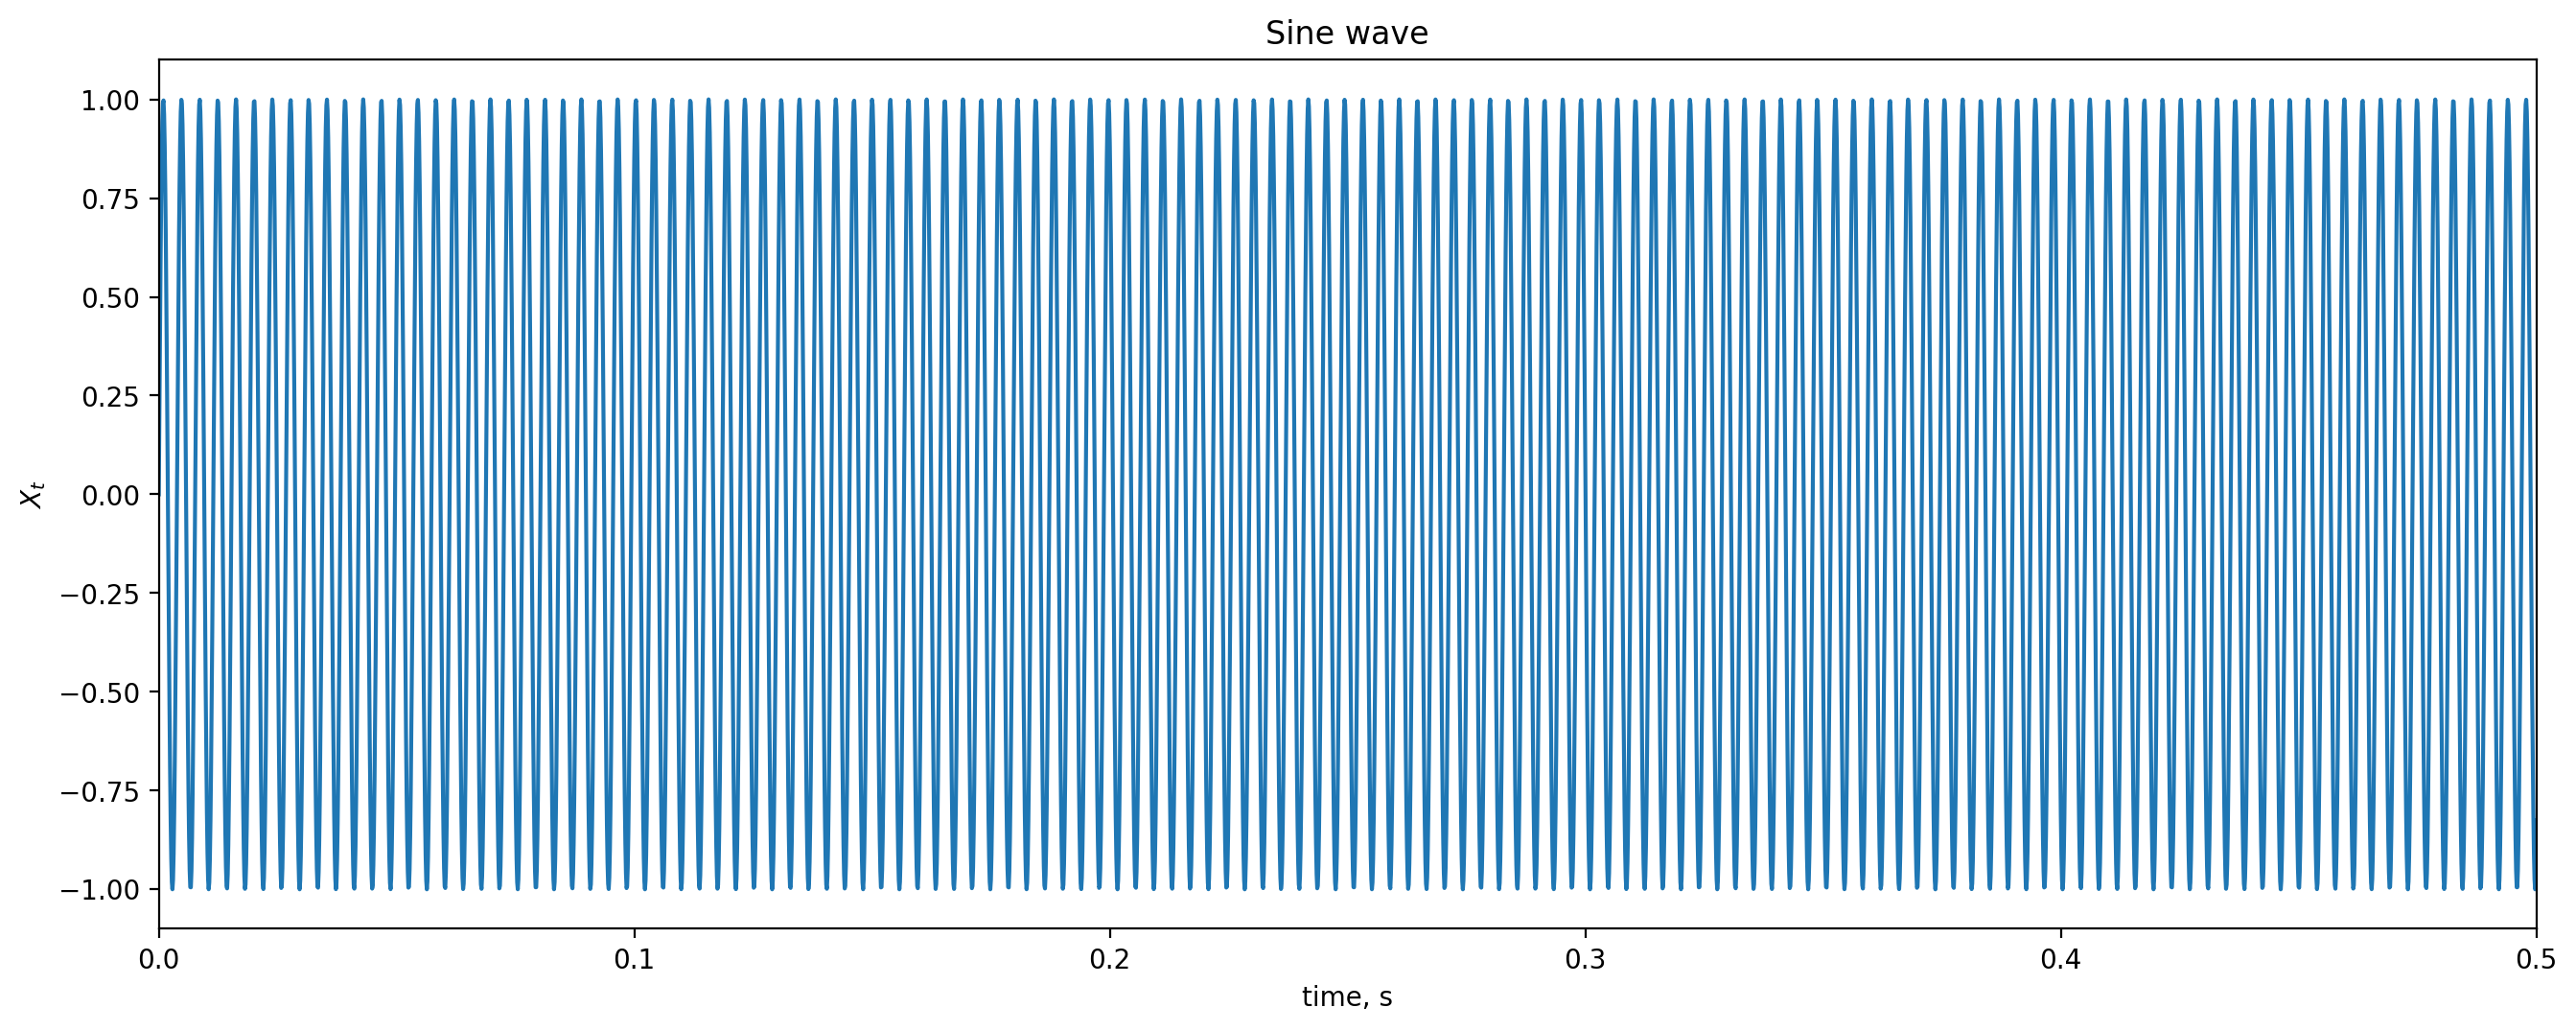

40000


In [12]:
sample_rate = 8000
t = np.arange(0, 5, 1.0/sample_rate)
freq = 261.625565
x = np.sin(2*t*np.pi*freq)

plt.figure(figsize=(16, 6), dpi=200)
plt.title("Sine wave")
plt.plot(t, x)
plt.xlim(0, 0.5)
plt.xlabel("time, s")
plt.ylabel("$X_t$")
plt.show()

print(len(x))
Audio(data=x, rate=sample_rate)

Для 5 секунд записи получили массив из 40000 чисел. Такая длина последовательности является слишком большой для того, чтобы подавать в рекуррентную сеть. Кроме того, если так делать, то на кажом шаге в рекуррентную сеть будет подаваться лишь одно число. Из-за этого векторные операции окажуться неэффективными и сеть будет тренироваться еще дольше.

Оптимальный вариант -- подавать короткие (500-2000 отсчетов) последовательности коротких векторов (100-200 элементов). Для этого применяют спектрограммы, filterbank или MFCC фичи. Мы будем использовать спектрограммы.

Спектрограмма -- картинка, где по горизонтальной оси отмечено время, а по вертикальной -- частота. Значение пикселя этой картинки в некоторой момент времени t с частотой f означает амплитуду (или квадрат амплитуды, или логарифм квадрата амплитуды в зависимости от реализации) колебания с частотой f в некотором [окне](https://en.wikipedia.org/wiki/Window_function) небольшой длины c центром в t.

На первой картинке ниже изображена спектрограмма построенного нами синусоидального сигнала. В идеале на ней должна быть одна горизонтальная линия $f = 261.6 Hz$. Но это не так, из-за того, что дискретизация и форма и размер выбранного [окна](https://en.wikipedia.org/wiki/Window_function) вносят свои помехи. На второй картинке снизу изображен срез этой спектрограммы в момент времени $t=0$. По горизонтальной оси отмечено время, по вертикальной -- логарифм мощности (квадрата амплитуды).

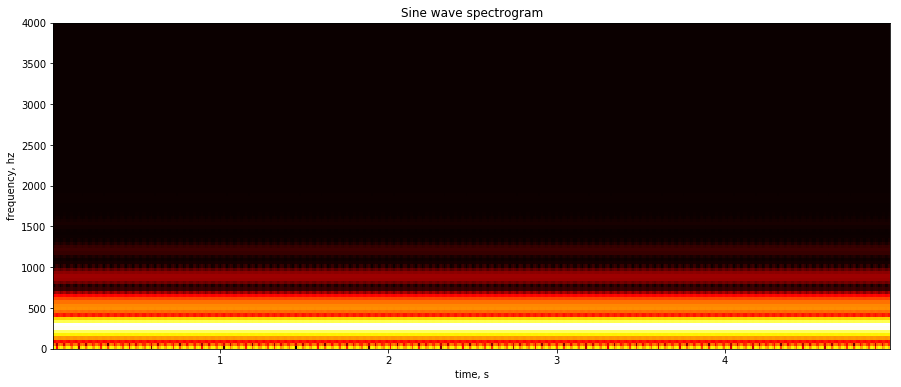

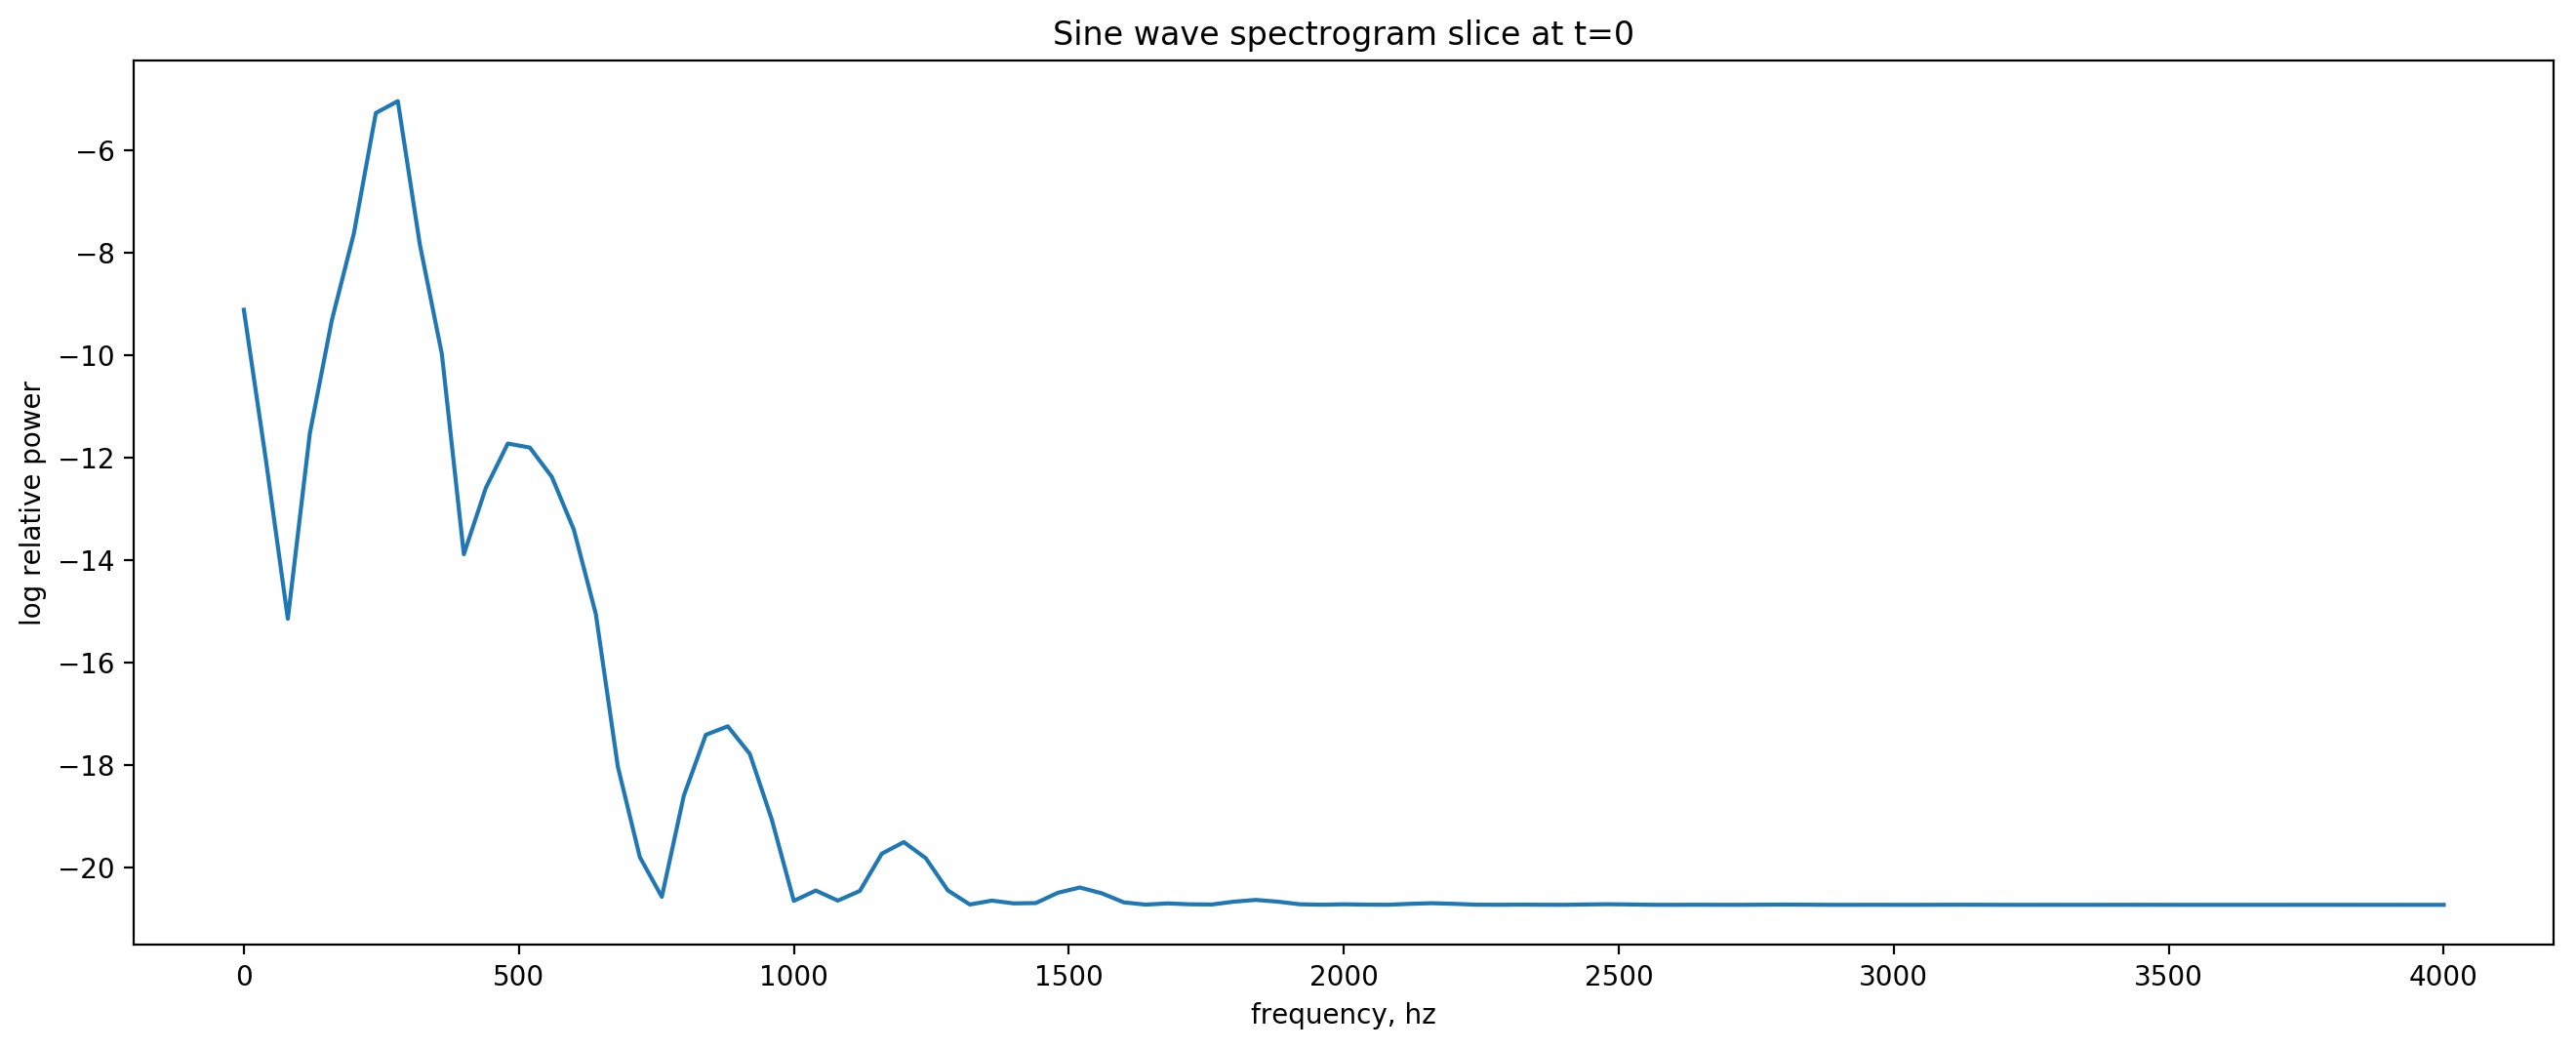

In [13]:
fs, ts, Sxx = extract_feats(sample_rate, x / x.max())
plt.figure(figsize=(15, 6))
plt.title("Sine wave spectrogram")
plt.pcolor(ts, fs, Sxx.T, cmap="hot")
plt.xlabel("time, s")
plt.ylabel("frequency, hz")
plt.show()

plt.figure(figsize=(16, 6), dpi=200)
plt.plot(fs, Sxx[0])
plt.title("Sine wave spectrogram slice at t=0")
plt.ylabel("log relative power")
plt.xlabel("frequency, hz")
plt.show()

Рассмотрим еще один сигнал -- на этот раз сумму трех синусоидальных волн с переменной частотой.

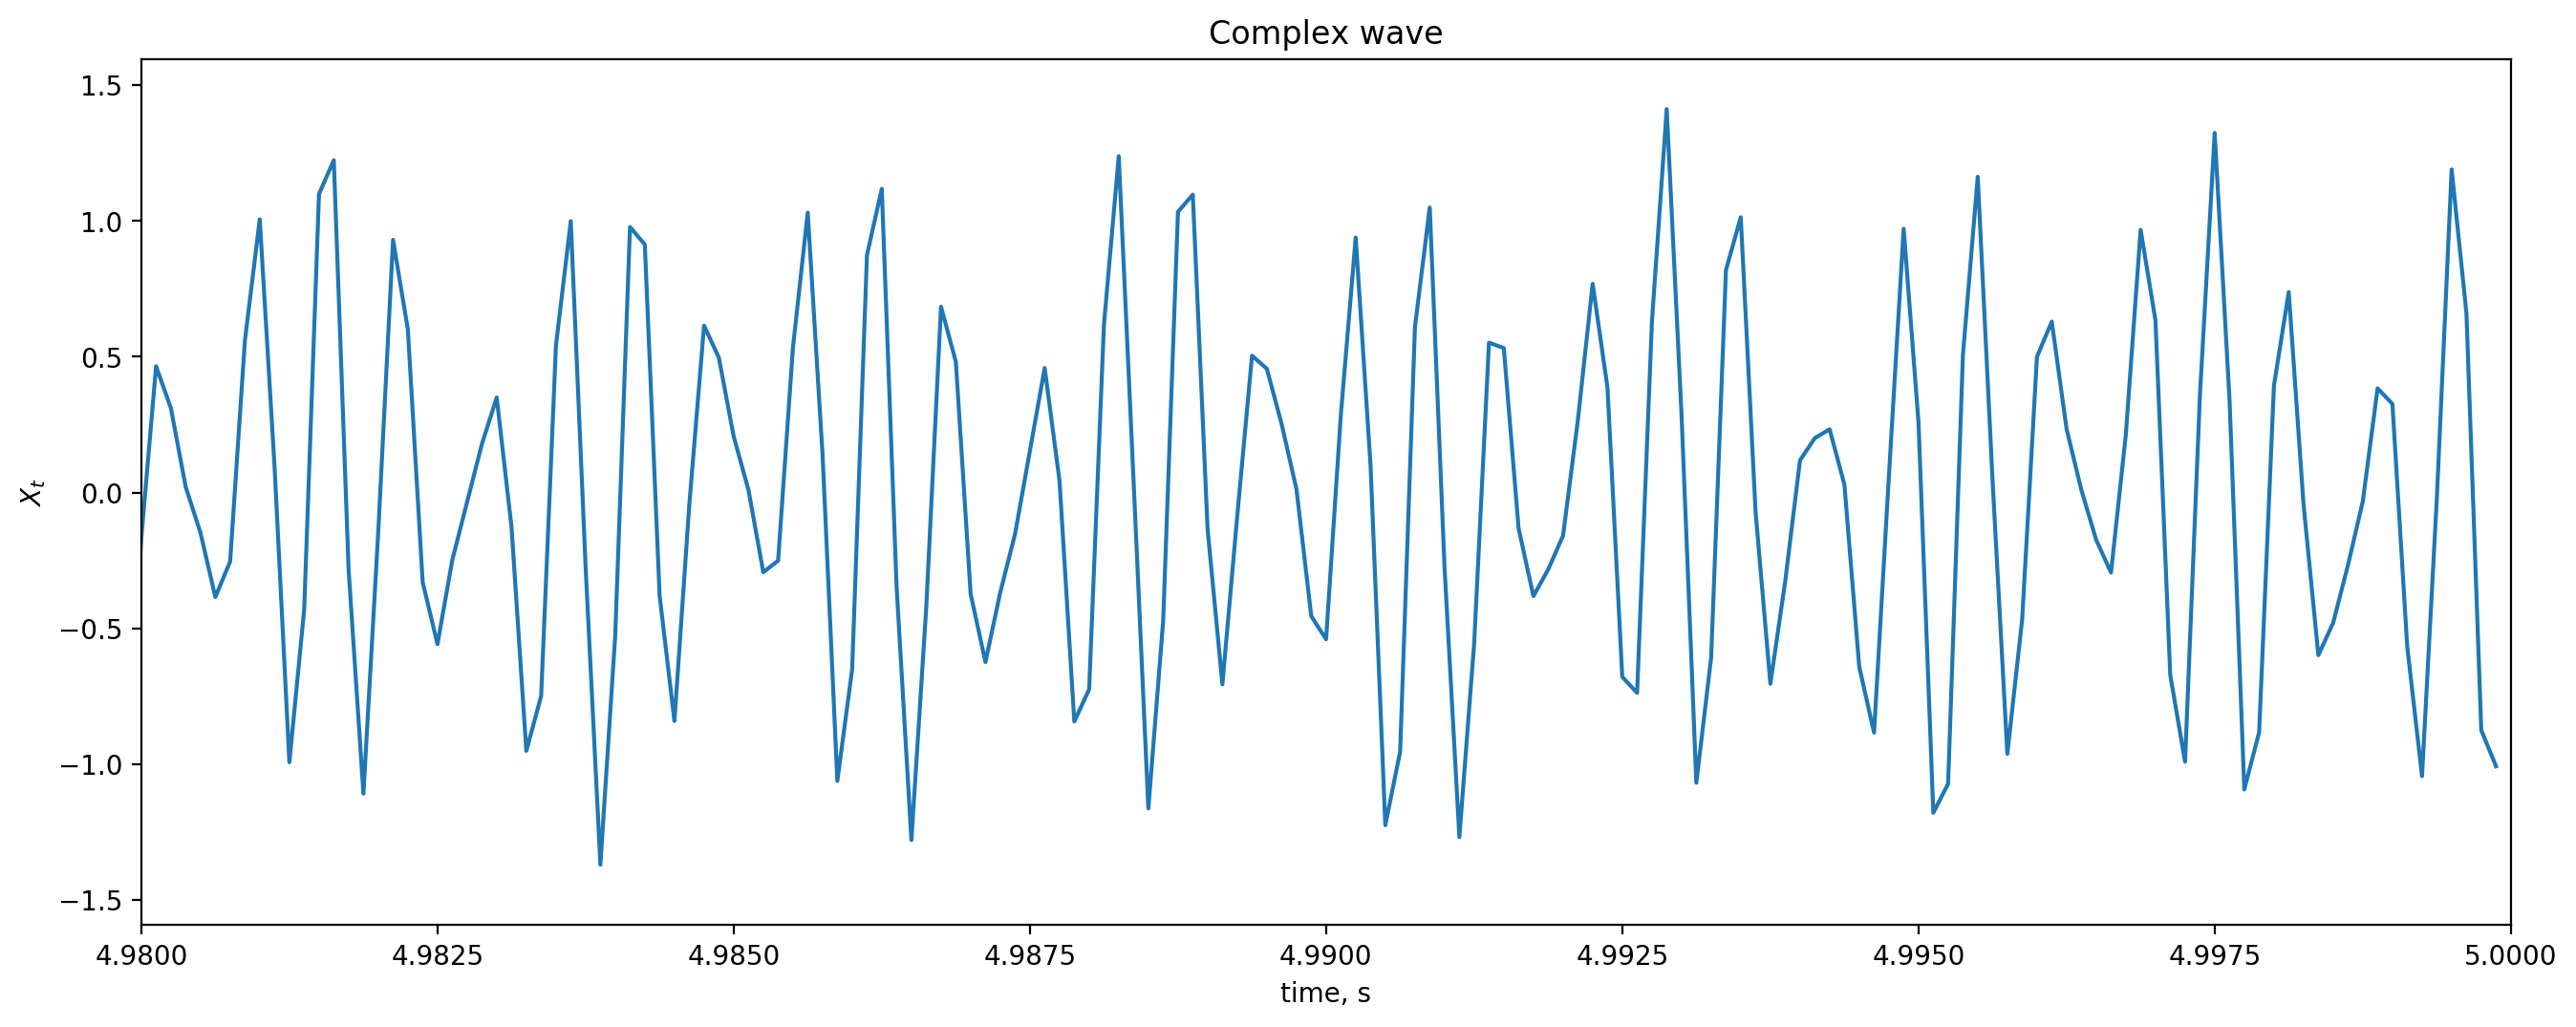

In [22]:
sample_rate = 8000
t = np.arange(0, 5, 1.0/sample_rate)
freq_1 = 261.625565
freq_2 = np.linspace(100, 2000, len(t))
x = 0.15 * np.sin(2*t*np.pi*freq_1) + 0.5 * np.sin(2*t*np.pi*freq_2/2) + 0.8* np.sin(2 * np.pi * (3000 * t - 20 * t ** 3))

plt.figure(figsize=(16, 6), dpi=200)
plt.title("Complex wave")
plt.plot(t, x)
plt.xlim(4.98, 5.0)
plt.xlabel("time, s")
plt.ylabel("$X_t$")
plt.show()

Audio(data=x, rate=sample_rate)

Спектрограммы в этом случае просто складываются.

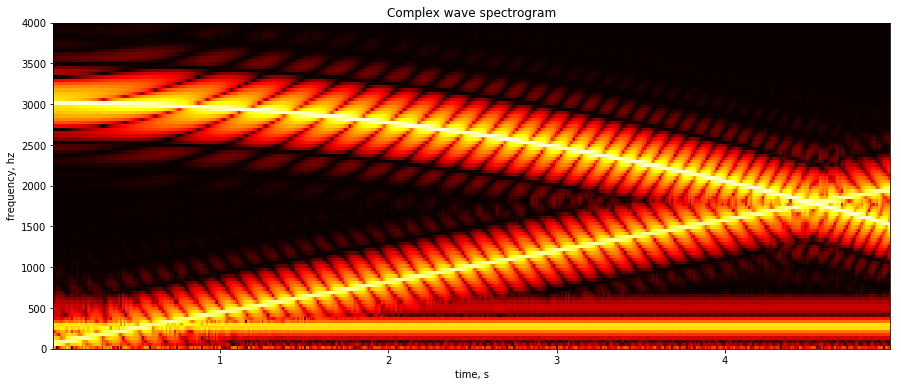

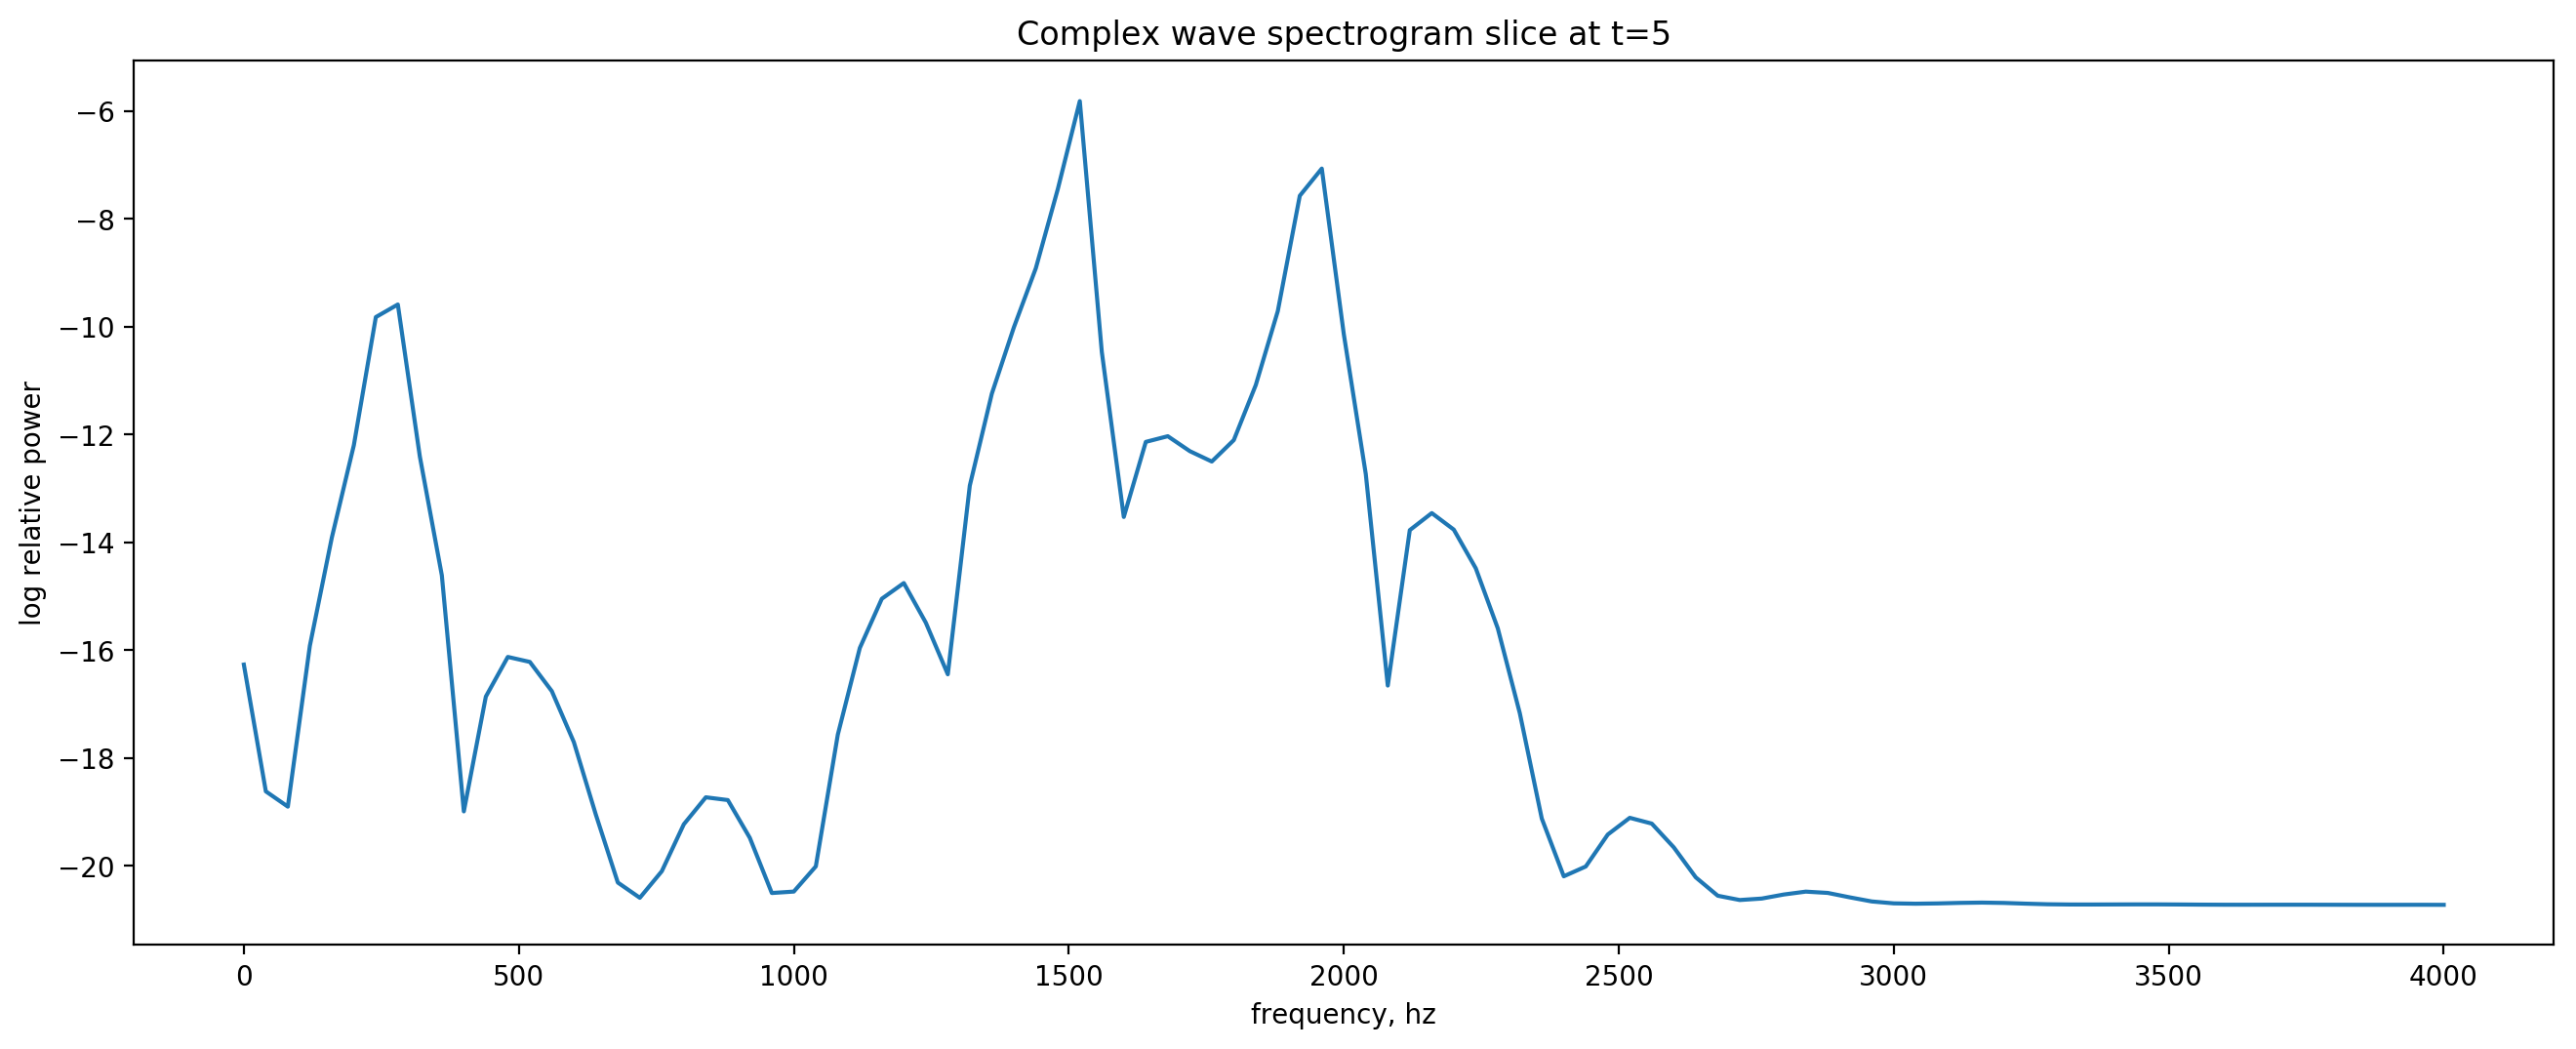

In [23]:
fs, ts, Sxx = extract_feats(sample_rate, x / x.max())
plt.figure(figsize=(15, 6))
plt.title("Complex wave spectrogram")
plt.pcolor(ts, fs, Sxx.T, cmap="hot")
plt.xlabel("time, s")
plt.ylabel("frequency, hz")
plt.show()

plt.figure(figsize=(16, 6), dpi=200)
plt.plot(fs, Sxx[-1])
plt.title("Complex wave spectrogram slice at t=5")
plt.ylabel("log relative power")
plt.xlabel("frequency, hz")
plt.show()

Загрузим звук произношения цифры 8 на английском из [free-spoken-digit-dataset](https://github.com/Jakobovski/free-spoken-digit-dataset) и посмотрим на аудиоформы и спектрограммы реальных данных.

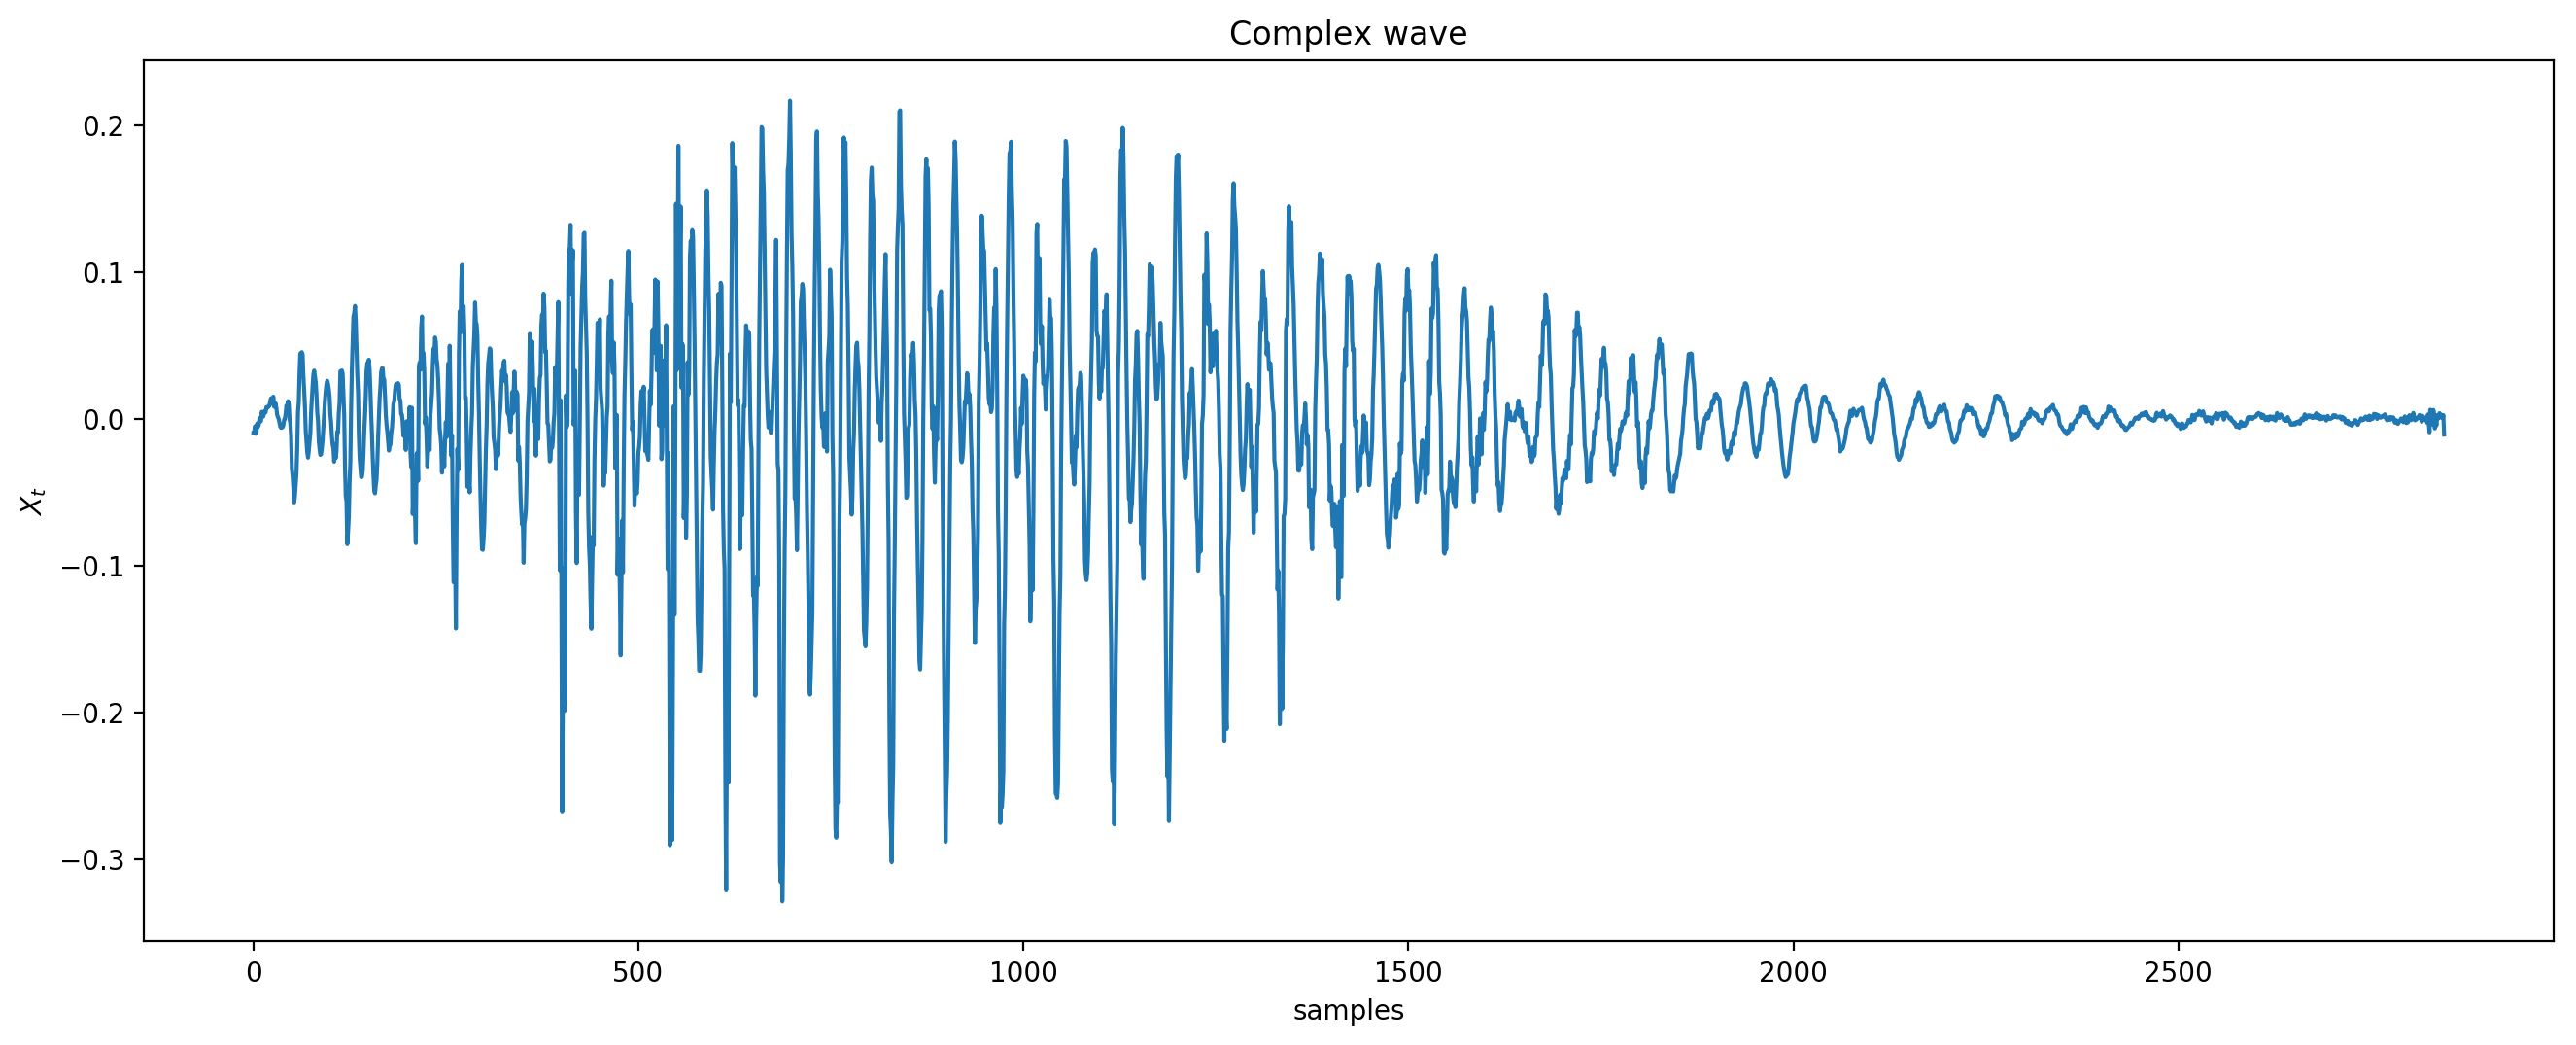

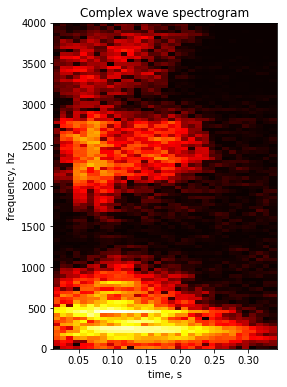

In [38]:
sample_rate, data = read_wav("free-spoken-digit-dataset/recordings/8_jackson_12.wav")

data = data[:, 0]

plt.figure(figsize=(16, 6), dpi=200)
plt.title("Complex wave")
plt.plot(data)
#plt.xlim(4.98, 5.0)
plt.xlabel("samples")
plt.ylabel("$X_t$")
plt.show()


fs, ts, Sxx = extract_feats(sample_rate, data)
plt.figure(figsize=(4, 6))
plt.title("Complex wave spectrogram")
plt.pcolor(ts, fs, Sxx.T, cmap="hot")
plt.xlabel("time, s")
plt.ylabel("frequency, hz")
plt.show()

Audio(data=data, rate=sample_rate)

## Архитектура нейросети для распознавания речи

In [39]:
print(Sxx.shape)

(34, 101)


Спектрограмма получается шейпа $(time, num\_feats)$, где time -- временная размерность, num_feats -- количество элементов в одном feature-векторе. В данном случае time = 34, num_feats = 101.

Вообще, так как спектрограмма -- это картинка, для распознавания речи можно использовать как [сверточные слои](http://cs231n.github.io/convolutional-networks/), так и рекуррентные. Мы будем использовать рекуррентные.

Будем использовать [free-spoken-digit-dataset](https://github.com/Jakobovski/free-spoken-digit-dataset). Это датасет с 1000 англоязычных произношениий цифр от 0 до 9 двумя людьми. Для полноценного распознавания речи 1000 фраз -- это очень мало, но в учебных целях и для рапсознавания цифр в частности такой подход вполне оправдан.

Нейросеть будет обучаться для предсказания буквы в каждый момент времени либо специального символа "blank". Последний слой нейросети будет выдавать score для каждой из букв и символа blank.

<img src="img/alignments_example.png"/>

Для трейнировки нейросети будем использовать [CTC loss](https://gab41.lab41.org/speech-recognition-you-down-with-ctc-8d3b558943f0) (connectionist temporal classification loss). Он доступен в tensorflow как [tf.nn.ctc_loss](https://www.tensorflow.org/api_docs/python/tf/nn/ctc_loss)

## Тренируем нейросеть

In [3]:
X, y = read_dataset("free-spoken-digit-dataset/recordings/")

/usr/local/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


In [4]:
lexicon = {
    0: "zero",
    1: "one",
    2: "two",
    3: "three",
    4: "four",
    5: "five",
    6: "six",
    7: "seven",
    8: "eight",
    9: "nine"
}

vocabulary = {chr(ord("a") + i): i for i in range(26)}
inv_vocabulary = dict(zip(vocabulary.values(), vocabulary.keys()))

In [5]:
SAMPLE_RATE = 8000
for i, data in enumerate(X):
    _, _, X[i] = extract_feats(SAMPLE_RATE, X[i])
for i, digit in enumerate(y):
    y[i] = list(map(lambda x: vocabulary[x], lexicon[y[i]]))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

'six'

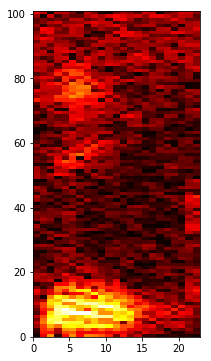

In [7]:
idx = 0
plt.figure(figsize=(3, 6))
plt.pcolor(X_train[idx].T, cmap="hot")
"".join(map(lambda x: inv_vocabulary[x], y_train[idx]))

In [8]:
g = tf.Graph()
with g.as_default():
    input_X = tf.placeholder(tf.float32, shape=[None, None, 101])
    labels = tf.sparse_placeholder(tf.int32)
    seq_lens = tf.placeholder(tf.int32, shape=[None])


    model = Sequential()
    model.add(Bidirectional(LSTM(128, return_sequences=True, implementation=2), input_shape=(None, 101)))
    model.add(Bidirectional(LSTM(128, return_sequences=True, implementation=2)))
    model.add(TimeDistributed(Dense(len(vocabulary) + 1)))
    
    final_seq_lens = seq_lens

    logits = model(input_X)
    logits = tf.transpose(logits, [1, 0, 2])

    ctc_loss = tf.reduce_mean(tf.nn.ctc_loss(labels, logits, final_seq_lens))
    # ctc_greedy_decoder? merge_repeated=True
    (decoded, ), _ = tf.nn.ctc_greedy_decoder(logits, final_seq_lens)
    ler = tf.reduce_mean(tf.edit_distance(tf.cast(decoded, tf.int32), labels))

    train_op = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(ctc_loss)

In [ ]:
sess = tf.InteractiveSession(graph=g)

In [ ]:
sess.run(tf.global_variables_initializer())
for epoch in range(1000):
    for X_batch, seq_lens_batch, y_batch, y_batch_orig in batch(X_train, y_train, 64):
        print(X_batch.shape)
        feed_dict = {
            input_X: X_batch,
            labels: y_batch,
            seq_lens: seq_lens_batch
        }
        train_loss, train_ler, train_decoded, true, _ = sess.run([ctc_loss, ler, decoded, labels, train_op], feed_dict=feed_dict)
    for X_batch, seq_lens_batch, y_batch, y_batch_orig in batch(X_test, y_test, 64):
        feed_dict = {
            input_X: X_batch,
            labels: y_batch,
            seq_lens: seq_lens_batch
        }
        test_loss, test_ler, test_decoded, true = sess.run([ctc_loss, ler, decoded, labels], feed_dict=feed_dict)
    print(f"{epoch}", train_loss, train_ler, decode(train_decoded, inv_vocabulary)[:10],  test_loss, test_ler)

(64, 65, 101)
(64, 79, 101)
(64, 84, 101)
(64, 75, 101)
(64, 64, 101)
(64, 83, 101)
(64, 77, 101)
(64, 66, 101)
(64, 85, 101)
(64, 84, 101)
(64, 78, 101)
(64, 77, 101)
(64, 81, 101)
(64, 78, 101)
(64, 70, 101)
(64, 84, 101)
0 33.0298 1.0 ['', '', '', '', '', '', '', '', '', ''] 31.6264 1.0
(64, 85, 101)
(64, 84, 101)
(64, 77, 101)
(64, 84, 101)
(64, 69, 101)
(64, 64, 101)
(64, 74, 101)
(64, 68, 101)
(64, 75, 101)
(64, 83, 101)
(64, 81, 101)
(64, 64, 101)
(64, 84, 101)
(64, 64, 101)
(64, 69, 101)
(64, 78, 101)
1 13.6233 1.0 ['', '', '', '', '', '', '', '', '', ''] 13.2905 1.0
(64, 77, 101)
(64, 85, 101)
(64, 66, 101)
(64, 84, 101)
(64, 84, 101)
(64, 72, 101)
(64, 75, 101)
(64, 70, 101)
(64, 79, 101)
(64, 83, 101)
(64, 65, 101)
(64, 78, 101)
(64, 67, 101)


KeyboardInterrupt: 

## Тестируем предобученную нейросеть

In [5]:
with open("model.pb", "rb") as fin:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(fin.read())


In [6]:
mapping = {' ': 6,
           "'": 22,
           'a': 14,
           'b': 9,
           'c': 16,
           'd': 20,
           'e': 8,
           'f': 18,
           'g': 0,
           'h': 10,
           'i': 12,
           'j': 25,
           'k': 23,
           'l': 15,
           'm': 17,
           'n': 19,
           'o': 2,
           'p': 4,
           'q': 24,
           'r': 1,
           's': 5,
           't': 11,
           'u': 3,
           'v': 13,
           'w': 7,
           'x': 26,
           'y': 21,
           'z': 27,
           'ă': 29,
           'ō': 28,
           'ť': 30}

inv_mapping = dict(zip(mapping.values(), mapping.keys()))

In [7]:
g = tf.Graph()
with g.as_default():
    tf.import_graph_def(graph_def, )

In [8]:
decoded = tf.SparseTensor(g.get_tensor_by_name("import/inference/CTCGreedyDecoder:0"),
                          g.get_tensor_by_name("import/inference/CTCGreedyDecoder:1"),
                          g.get_tensor_by_name("import/inference/CTCGreedyDecoder:2"))

input_features = g.get_tensor_by_name("import/inference/input_features:0")
input_seq_lens = g.get_tensor_by_name("import/inference/input_seq_lengths:0")

In [30]:
sess = tf.InteractiveSession(graph=g)
sess.run(tf.global_variables_initializer())

In [60]:
rate, data = read_wav("zen.wav")
Audio(data=data[:, 0], rate=rate)
overlap_frames = int(rate * 0.015)
window_frames = int(rate*0.025)
_, _, Sxx = spectrogram(data[:, 0], rate, nperseg=window_frames, noverlap=overlap_frames, scaling="spectrum")
Sxx = np.log(1e-9 + Sxx.T)

In [61]:
Sxx.reshape(1, *Sxx.shape).shape

(1, 420, 201)

In [62]:
decoded_output = sess.run(decoded, feed_dict={input_features: Sxx.reshape(1, *Sxx.shape), input_seq_lens: [Sxx.shape[0]]})

In [63]:
decode(decoded_output, inv_mapping)

['explascit is better for then emplercip']

## Заключение

Что можно попробовать дома самому:
* Попробовать [сверточные слои](http://cs231n.github.io/convolutional-networks/)
* Попробовать обучиться на [TEDLIUM](http://www.openslr.org/7/) и [TEDLIUMv2](http://www.openslr.org/19/)
* Попробовать декодировать с [языковой моделью](http://www.cs.nyu.edu/~mohri/pub/hbka.pdf), [пример в коде Eesen](https://github.com/srvk/eesen/blob/master/src/decoderbin/decode-faster.cc)
* Data augmentation